# Temporal Fusion Transformer (TFT)

## Why We Chose Temporal Fusion Transformer (TFT)

Our exploratory data analysis revealed several important characteristics in the Bitcoin fee series that guided our model choice:

### Key Observations from EDA
- **Strong temporal patterns**: Clear intraday cycles and short-term dependencies in fee fluctuations.
- **Volatility and sharp spikes**: Frequent, irregular surges in transaction fees make point estimation challenging.
- **Multivariate dependencies**: Fee dynamics are influenced by multiple time-varying factors with non-linear interactions.
- **Lagged effects**: Historical values of both the target and covariates impact future behavior.

### Why TFT is a Good Fit
- **Multi-horizon forecasting**: Captures both short-term spikes and longer trends in one pass.
- **Attention mechanism**: Learns which time steps and variables are most relevant at each point.
- **Static + time-varying input support**: Integrates contextual and real-time signals effectively.
- **Quantile-based loss**: Provides uncertainty-aware forecasts, especially valuable under volatile market conditions.
- **Interpretable outputs**: Offers insights into feature importance and temporal relevance.

> Given these insights, TFT stands out as a model capable of handling the complexity, volatility, and interpretability needs revealed through EDA.


##  Import

In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from lightning.pytorch import Trainer
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from torch import Tensor
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss, MultiHorizonMetric
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting.metrics import MAPE, MAE, RMSE
import torch.nn as nn
import numpy as np
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import torch.nn.functional as F
import matplotlib.pyplot as plt
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
from lightning.pytorch.tuner import Tuner

import os
import sys
from pathlib import Path
import pickle

# Add ../src to the Python module search path
src_path = Path("..") / "src"
sys.path.append(str(src_path.resolve()))

torch.set_float32_matmul_precision('high')

## Step 1: Prepare Raw Data for Temporal Fusion Transformer (TFT)

In this step, we transform the raw Bitcoin mempool and fee dataset into a clean, long-format structure optimized for TFT. This involves:
- Removing noise and irrelevant features
- Resampling at 15-minute intervals for uniform time steps
- Assigning one row per (`series_id`, timestamp) pair (long format)
- Engineering cyclical features to capture time-of-day, day-of-week, and month effects
- Applying log transforms to skewed histogram features
- Adding lagged values to enable autoregressive learning

Proper preprocessing ensures TFT can effectively learn temporal dynamics without risk of data leakage or misalignment.


In [15]:
# Import custom preprocessing function to clean and structure raw input
from preprocess_raw_parquet import preprocess_raw_parquet

# Load and clean raw dataset from Parquet file
df = preprocess_raw_parquet("../data/raw/mar_5_may_12.parquet")  # Outputs uniform 15-min time series
df = df.iloc[:-96]
df.tail()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-05-11 18:45:00,7.225843e+05,470774.833333,1282.333333,1.334593e+06,0.580391,1.333333,1.000000,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-11 19:00:00,3.872140e+05,240659.750000,819.666667,6.658160e+05,0.000000,1.000000,1.000000,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-11 19:15:00,1.479687e+06,917250.833333,2951.000000,2.899317e+06,2.102116,2.333333,1.000000,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-11 19:30:00,1.600430e+06,997964.500000,3674.333333,5.290451e+06,3.045255,4.000000,2.000000,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-05-11 19:45:00,1.577521e+06,997990.250000,3736.666667,5.244567e+06,3.251342,4.000000,2.666667,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Add time encodings, reshape to long format, and assign time_idx
from transform_fee_data_dl import transform_fee_data_dl
df = transform_fee_data_dl(df)

# Print column names to verify added features
print(df.columns.tolist())

['timestamp', 'series_id', 'target', 'mempool_blocks_blockSize', 'mempool_blocks_blockVSize', 'mempool_blocks_nTx', 'mempool_blocks_totalFees', 'mempool_blocks_medianFee', 'mempool_count', 'mempool_vsize', 'mempool_total_fee', 'difficulty_adjustment_progressPercent', 'difficulty_adjustment_difficultyChange', 'difficulty_adjustment_remainingBlocks', 'difficulty_adjustment_remainingTime', 'difficulty_adjustment_previousTime', 'difficulty_adjustment_nextRetargetHeight', 'difficulty_adjustment_timeAvg', 'difficulty_adjustment_adjustedTimeAvg', 'difficulty_adjustment_timeOffset', 'difficulty_adjustment_expectedBlocks', 'price_USD', 'mempool_fee_histogram_bin_1_2', 'mempool_fee_histogram_bin_2_3', 'mempool_fee_histogram_bin_3_4', 'mempool_fee_histogram_bin_4_5', 'mempool_fee_histogram_bin_5_6', 'mempool_fee_histogram_bin_6_7', 'mempool_fee_histogram_bin_7_8', 'mempool_fee_histogram_bin_8_9', 'mempool_fee_histogram_bin_9_10', 'mempool_fee_histogram_bin_10_12', 'mempool_fee_histogram_bin_12_14

In [17]:
# Add lag features (past values) for autoregressive modeling
from add_lag_features import add_lag_features

# Define columns to exclude from lagging
exclude_cols = [
    'timestamp', 'series_id', 'time_idx',
    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
    'month_sin', 'month_cos', 'minute_sin', 'minute_cos'
]

# Add lag features for all numeric inputs (excluding cyclic and ID columns)
for col in df.columns:
    if (
        col not in exclude_cols
        and not col.startswith("mempool_fee_histogram_bin")
    ):
        df = add_lag_features(df, col, lag_step=96)  # Use past 1-day window for lag features

# Print column names to verify added features
print(df.columns.tolist())

['timestamp', 'series_id', 'target', 'mempool_blocks_blockSize', 'mempool_blocks_blockVSize', 'mempool_blocks_nTx', 'mempool_blocks_totalFees', 'mempool_blocks_medianFee', 'mempool_count', 'mempool_vsize', 'mempool_total_fee', 'difficulty_adjustment_progressPercent', 'difficulty_adjustment_difficultyChange', 'difficulty_adjustment_remainingBlocks', 'difficulty_adjustment_remainingTime', 'difficulty_adjustment_previousTime', 'difficulty_adjustment_nextRetargetHeight', 'difficulty_adjustment_timeAvg', 'difficulty_adjustment_adjustedTimeAvg', 'difficulty_adjustment_timeOffset', 'difficulty_adjustment_expectedBlocks', 'price_USD', 'mempool_fee_histogram_bin_1_2', 'mempool_fee_histogram_bin_2_3', 'mempool_fee_histogram_bin_3_4', 'mempool_fee_histogram_bin_4_5', 'mempool_fee_histogram_bin_5_6', 'mempool_fee_histogram_bin_6_7', 'mempool_fee_histogram_bin_7_8', 'mempool_fee_histogram_bin_8_9', 'mempool_fee_histogram_bin_9_10', 'mempool_fee_histogram_bin_10_12', 'mempool_fee_histogram_bin_12_14

In [18]:
# Define key modeling parameters
FREQ = "15min"        # Time resolution of the data
ENC_LEN = 672         # Encoder length: 7 days = 672 × 15min
PRED_STEPS = 96       # Prediction length: 1 day = 96 × 15min
BATCH_SIZE = 32       # Batch size for training
NUM_WORKERS = 4       # Number of workers for data loading

In [22]:
# Split data into train/validation sets and normalize
from split_series import split_series
from scale_series import scale_series

# Set cutoff to reserve final day for testing and day before that for validation
last_idx = df.time_idx.max() - PRED_STEPS
training_cutoff = last_idx - PRED_STEPS

# Split and standardize the features
df_train, df_valid = split_series(df, PRED_STEPS=96)
df_train, df_valid, scaler = scale_series(df_train, df_valid)

# View training set structure
df_train.head()

,timestamp,series_id,target,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,mempool_count,mempool_vsize,...,difficulty_adjustment_difficultyChange_lag_96,difficulty_adjustment_remainingBlocks_lag_96,difficulty_adjustment_remainingTime_lag_96,difficulty_adjustment_previousTime_lag_96,difficulty_adjustment_nextRetargetHeight_lag_96,difficulty_adjustment_timeAvg_lag_96,difficulty_adjustment_adjustedTimeAvg_lag_96,difficulty_adjustment_timeOffset_lag_96,difficulty_adjustment_expectedBlocks_lag_96,price_USD_lag_96
0,2025-03-05 02:00:00,recommended_fee_economyFee,2.000000,1.718776,0.315714,-1.946223,-0.714628,-0.480730,-0.409374,2.866116,...,0.131665,0.010834,0.026676,0.27719,0.294297,-0.177621,-0.179539,0.0,-0.023812,-0.352336
1,2025-03-05 02:15:00,recommended_fee_economyFee,2.666667,0.592171,0.315926,-0.147425,-0.204269,-0.091919,-0.195878,2.980191,...,0.131665,0.010834,0.026676,0.27719,0.294297,-0.177621,-0.179539,0.0,-0.023812,-0.352336
2,2025-03-05 02:30:00,recommended_fee_economyFee,2.000000,1.366235,0.316204,-1.819699,-0.711815,-0.462252,-0.385740,2.971472,...,0.131665,0.010834,0.026676,0.27719,0.294297,-0.177621,-0.179539,0.0,-0.023812,-0.352336
3,2025-03-05 02:45:00,recommended_fee_economyFee,2.333333,1.218178,0.316233,-1.452224,-0.609854,-0.402567,-0.311556,3.075400,...,0.131665,0.010834,0.026676,0.27719,0.294297,-0.177621,-0.179539,0.0,-0.023812,-0.352336
4,2025-03-05 03:00:00,recommended_fee_economyFee,3.000000,0.507187,0.316165,-0.050980,-0.186345,-0.094006,-0.054725,3.155711,...,0.131665,0.010834,0.026676,0.27719,0.294297,-0.177621,-0.179539,0.0,-0.023812,-0.352336


### Why This Step Is Crucial for TFT
- Maintains causality: Ensures predictions are only based on past data.
- Supports encoder-decoder structure: Enables sliding-window learning design.
- Avoids information leakage: Keeps future targets out of the training process.
- Facilitates robust validation: Mimics real deployment conditions using temporal hold-out.
These steps ensure that the TFT model can learn meaningful patterns in fee dynamics and generalize well to future unseen time windows.

## 2: Construct TFT-Compatible Datasets (Training & Validation)

This step prepares the data loaders used for training and validating the Temporal Fusion Transformer (TFT) model.  
We explicitly define **which covariates are known at prediction time** (e.g., calendar features, lagged values) versus those that are **unknown** (e.g., real-time mempool, difficulty, and price data).

Proper dataset construction ensures:
- No future information leaks into the training process
- TFT receives clear signal from autoregressive (lagged) and temporal feature
- Overlapping windows are handled with correct alignment between encoder and decoder
- Targets are normalized per series to ensure stable optimization

---

### Why This Step?

TFT is a **sequence-to-sequence attention-based model** that depends heavily on structured temporal data. It requires:
- Separation of **known** vs. **unknown** features
- Differentiation between **static**, **time-varying known**, and **time-varying unknown** inputs
- **Sliding-window training** using teacher forcing
- Built-in **target normalization** and encoder padding

Creating a `TimeSeriesDataSet` handles all of these requirements seamlessly — preparing your data for training, validation, and prediction with minimal manual work.

---

### Dataset Composition

| Component                     | Description                                                                 |
|------------------------------|-----------------------------------------------------------------------------|
| `target`                     | The variable to forecast (e.g., `recommended_fee_fastestFee`)              |
| `group_ids`                  | Time series identifier (e.g., `series_id`)                                 |
| `real_covs`                  | Dynamic real-valued signals from mempool, difficulty, and BTC price        |
| `time_varying_known_reals`   | Features known ahead of time (e.g., calendar time + lagged covariates)     |
| `time_varying_unknown_reals` | Features not known at prediction time (e.g., target, current mempool state)|
| `target_normalizer`          | Normalizes target values per series using `GroupNormalizer`                |
| Other features               | Relative time index, encoder length, and target statistics are auto-added |

---

This structure ensures that your input data aligns with TFT’s architecture, enabling effective multi-horizon learning on Bitcoin transaction fee dynamics.


In [39]:
# Identify real-valued features from key sources
real_covs = [
    c for c in df_train.columns if c.startswith(("mempool", "difficulty", "price"))
]

# Lagged features are considered "known" at prediction time
known_lagged_covs = [
    c
    for c in df_train.columns
    if (
        "_lag_" in c
        and (
            c.startswith("mempool_")
            or c.startswith("difficulty_")
            or c.startswith("price_")
            or c.startswith("target")
        )
    )
]

# Unlagged real-valued features are "unknown" at prediction time
unknown_real_covs = [c for c in real_covs if c not in known_lagged_covs]

# Create training dataset with appropriate feature definitions
tft_ds = TimeSeriesDataSet(
    df_train,
    time_idx="time_idx",  # Required time index
    target="target",  # Target variable (e.g., recommended_fee_fastest)
    group_ids=["series_id"],  # Unique series per fee type
    min_encoder_length=ENC_LEN // 2,  # For variable-length sequences
    max_encoder_length=ENC_LEN,  # Full encoder context: 7 days
    min_prediction_length=1,
    max_prediction_length=PRED_STEPS,  # Forecast 1 day ahead (96 steps)
    # Static (non-changing) categorical features, such as series ID
    static_categoricals=["series_id"],
    # Known inputs at forecast time — calendar and lagged values
    time_varying_known_reals=[
        "time_idx",
        "hour_sin",
        "hour_cos",
        "day_of_week_sin",
        "day_of_week_cos",
        "month_sin",
        "month_cos",
        "minute_sin",
        "minute_cos",
    ]
    + known_lagged_covs,
    # Unknown inputs
    time_varying_unknown_reals=["target"] + unknown_real_covs,
    # Normalize target independently per time series
    target_normalizer=GroupNormalizer(groups=["series_id"]),
    # Add helper features for better learning
    add_relative_time_idx=True,  # Adds relative time indices (0...N)
    add_target_scales=True,  # Adds per-series target mean and std
    add_encoder_length=True,  # Adds actual encoder length (for padding)
)

# Validation set: replicate structure from training set
val_ds = TimeSeriesDataSet.from_dataset(
    tft_ds,
    df_valid,
    predict=True,
    stop_randomization=True,  # Always use deterministic windows for eval
)

# Convert to PyTorch DataLoaders for training and validation
num_workers = min(4, os.cpu_count())

train_dl = tft_ds.to_dataloader(
    train=True, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers
)

val_dl = val_ds.to_dataloader(
    train=False,
    batch_size=BATCH_SIZE * 10,  # Larger batch size for evaluation
    shuffle=False,
    num_workers=num_workers,
)


### Why This Step Matters
- Explicit feature categorization ensures the model doesn’t cheat by accessing future data
- Lagged and cyclical inputs allow learning complex temporal dependencies
- Consistent normalizers ensure targets are scaled per-series, reducing training variance
- Encapsulation via TimeSeriesDataSet simplifies batch preparation, prediction slicing, and inference

This design prepares your Bitcoin fee time series for multi-horizon forecasting in a reliable, interpretable, and leak-free manner.

## 3: Custom Loss — MAE with Standard Deviation and Deviation Penalties

In highly volatile time series like Bitcoin transaction fees, capturing **not just the mean**, but also the **variance** and **shape** of the signal is critical.  
A model trained purely with MAE might predict smooth outputs that minimize average error but completely miss spikes — which are crucial for users estimating fee costs.

To address this, we use a custom loss function: `MAEWithStdPenalty`.

---

### Why Use `MAEWithStdPenalty`?

This loss improves over traditional MAE by adding two structure-aware penalties:

1. **Standard deviation penalty**  
   Encourages the predicted variance to match the target’s variance — helping the model learn realistic volatility.
   
2. **Deviation shape penalty**  
   Encourages the model to align the **shape** of the predicted curve with the target curve — ensuring spikes and valleys are in the right place.

Together with MAE, these ensure the model learns accurate and expressive predictions.

---

### Component Breakdown

| Component         | Description |
|------------------|-------------|
| **Base MAE**     | `y_pred - target` — captures point error |
| **Std Penalty**  | `std(y_pred) - std(target)` — penalizes incorrect volatility |
| **Deviation Penalty** | `(y_pred - mean) - (target - mean)` — penalizes mismatched curve shape |
| **Weighted Terms** | Penalties are scaled by how poorly the model performs, with optional clipping to avoid instability |


Final loss:
total_loss = base_loss  + std_weight × w_std × std_penalty + de_weight × w_dev × dev_error

---

### Example

Ground Truth: y_true = [1.0, 2.0, 3.0]

Model A: y_pred_a = [0.0, 2.0, 4.0] ← Over/under-predicts symmetrically (mirrors extremes)

Model B: y_pred_b = [2.0, 2.0, 2.0] ← Predicts flat mean (smooths out dynamics)

Now evaluate them on all loss components:

| Model | MAE  | STDdiff | DevErr | MAE + STD + Dev |
|-------|------|---------|--------|------------------|
| **A** | 0.67 | 0.00    | 1.33   | **2.0**         |
| **B** | 0.67 | 0.82    | 0.67   | **2.16**         |

Model A gets the spread (STDdiff = 0) but flips the structure (high DevErr).

Model B captures the mean, but smooths out the dynamics (high STDdiff, moderate DevErr).

But in total we prefer model A because A has a better prediction power, it capture the trend correctly.

---

### Benefits for Fee Forecasting

| Challenge                     | How the Loss Solves It |
|------------------------------|------------------------|
| Smooth predictions that ignore volatility | Std penalty enforces realistic variation |
| Spikes/dips underpredicted   | Deviation penalty reinforces structural fidelity |
| Mean-only training misleads  | MAE is enhanced by distributional constraints |
| Volatile fee environment     | Handles high variance with stability controls |

---

By incorporating this composite loss, our model learns **not just what the fee should be**, but also **how it behaves over time**, which is essential for users and applications that depend on accurate fee forecasting.



In [40]:
class MAEWithStdPenalty(MultiHorizonMetric):
    def __init__(
        self,
        std_weight=1.0,
        de_weight=1.0,
        clip_weight_std=None,
        clip_weight_dev=None,
        reduction="mean",
        **kwargs
    ):
        """
        Custom loss combining Mean Absolute Error (MAE) with std and deviation shape penalties.

        Parameters:
        std_weight (float): Weight for std deviation penalty.
        de_weight (float): Weight for deviation error penalty.
        clip_weight_std (float or None): Max clip value for std penalty weight.
        clip_weight_dev (float or None): Max clip value for deviation penalty weight.
        reduction (str): 'mean', 'sum', or 'none'.
        """
        super().__init__(reduction=reduction, **kwargs)
        self.std_weight = std_weight
        self.de_weight = de_weight
        self.clip_weight_std = clip_weight_std
        self.clip_weight_dev = clip_weight_dev

    def loss(self, y_pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        y_pred_point = self.to_prediction(y_pred)  # shape (B, T)

        # Base MAE
        base_loss = torch.abs(y_pred_point - target)  # (B, T)
        mae = base_loss.mean(dim=1, keepdim=True)  # (B, 1)

        # Std penalty
        pred_std = torch.std(y_pred_point, dim=1, keepdim=True)  # (B, 1)
        true_std = torch.std(target, dim=1, keepdim=True)  # (B, 1)
        std_penalty = torch.abs(pred_std - true_std)  # (B, 1)

        w_std = mae / (std_penalty + 1e-8)  # (B, 1)
        if self.clip_weight_std is not None:
            w_std = w_std.clamp(max=self.clip_weight_std)

        # Deviation penalty
        pred_mean = y_pred_point.mean(dim=1, keepdim=True)  # (B, 1)
        true_mean = target.mean(dim=1, keepdim=True)  # (B, 1)
        pred_dev = y_pred_point - pred_mean  # (B, T)
        true_dev = target - true_mean
        dev_error = torch.abs(pred_dev - true_dev)  # (B, T)

        w_dev = base_loss / (dev_error + 1e-8)  # shape (B, T)

        if self.clip_weight_dev is not None:
            w_dev = w_dev.clamp(max=self.clip_weight_dev)

        # Final loss
        total_loss = (
            base_loss
            + self.std_weight * w_std * std_penalty
            + self.de_weight * w_dev * dev_error
        )

        return total_loss


loss_fn = MAEWithStdPenalty()


## 4. Prototype Temporal Fusion Transformer and Explore Learning Rate

Before committing to a full model definition and training schedule, we can **optionally prototype** the Temporal Fusion Transformer (TFT) and run a quick learning rate sweep. This helps assess whether our data pipeline is working and gives an estimate for a stable learning rate range.


### Why This Step?

- Quickly validate that your `TimeSeriesDataSet` and `DataLoader` objects are compatible with TFT.
- Use `lr_find()` to get a **suggested learning rate** for better training stability.
- Explore model capacity (e.g., number of parameters) without running full training.


In [41]:
# Set global random seed for reproducibility
pl.seed_everything(42)

# Minimal trainer with gradient clipping (important for LSTM stability)
trainer = pl.Trainer(
    accelerator="gpu",
    gradient_clip_val=0.1,
)

# Provisional TFT configuration — useful for debugging or learning rate tuning
tft = TemporalFusionTransformer.from_dataset(
    train_ds,
    learning_rate=1e-4,
    hidden_size=32,
    hidden_continuous_size=8,
    lstm_layers=2,
    dropout=0.2,
    loss=loss_fn,
    output_size=1,
    weight_decay=1e-4,
    reduce_on_plateau_patience=0,
)

# Check model size
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\davyx\anaconda3\envs\satcast\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\davyx\anaconda3\envs\satcast\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 218.8k


In [266]:
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    max_lr=10.0,
    min_lr=1e-6,
    num_training=300
)

# Print suggested learning rate (can be slightly underestimated due to the nature of this tuner)
print(f"suggested learning rate: {res.suggestion()}")


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/300 [00:00<?, ?it/s]

LR finder stopped early after 231 steps due to diverging loss.
Learning rate set to 0.0009190377133632595
Restoring states from the checkpoint path at C:\Users\davyx\桌面\学习\Capstone_SatCast_Trilemma\analysis\.lr_find_8c0e456a-ef5c-43c8-9280-47f29ad083c1.ckpt
Restored all states from the checkpoint at C:\Users\davyx\桌面\学习\Capstone_SatCast_Trilemma\analysis\.lr_find_8c0e456a-ef5c-43c8-9280-47f29ad083c1.ckpt


suggested learning rate: 0.0009190377133632595


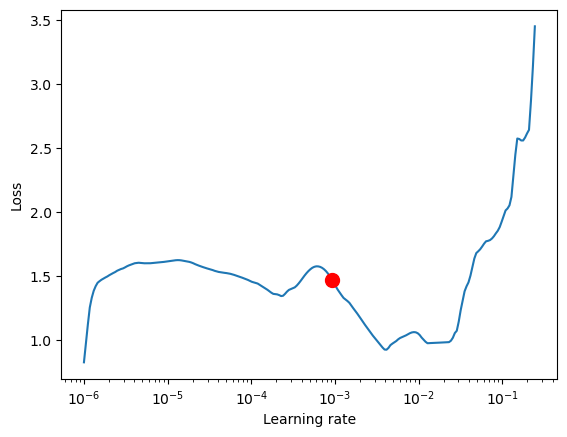

C:\Users\davyx\AppData\Local\Temp\ipykernel_29552\1348712520.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [267]:
fig = res.plot(show=True, suggest=True)
fig.show()

### Why This Is Helpful (But Optional)

- Allows early **debugging** of model architecture and data pipeline
- Identifies a **safe learning rate** range without committing to full training
- Can be skipped or deferred until after full feature engineering and hyperparameter tuning

You can revisit or overwrite this configuration later with your final model and trainer setup.

---

## 5. Model, Callbacks, Trainer, and Optimizer Customization

In this section, we finalize our TFT model setup and training configuration, including:

1. **Model definition** with custom loss  
2. **Callback setup** for early stopping, checkpointing, and LR logging  
3. **Trainer configuration** with mixed precision, gradient clipping, and validation schedule  
4. **Custom optimizer and scheduler** bound to the TFT instance

### 5.1 Instantiate Final TFT Model
**Why this step is important:**  
This step defines the actual architecture used for training. It includes the number of LSTM layers, hidden sizes, dropout, and the choice of loss function — all of which determine the model’s capacity, regularization, and optimization objective.

In [196]:
# Instantiate Temporal Fusion Transformer model
tft = TemporalFusionTransformer.from_dataset(
    train_ds,
    learning_rate=res.suggestion(),  # Initial learning rate
    hidden_size=32,  # Size of LSTM and attention layers
    hidden_continuous_size=8,  # Internal size for continuous variables, should be <= hidden size
    lstm_layers=2,  # Number of LSTM layers (recommended 2 by pytorch document)
    dropout=0.2,  # Dropout for regularization (recommended 0.1-0.3 by pytorch document)
    loss=MAEWithDynamicStdAndDeviationPenalty(beta=1.0, clip_weight=10.0),  # Quantile regression loss
    output_size=1,  # One output per quantile
    weight_decay=1e-4,  # L2 regularization strength
    reduce_on_plateau_patience=0,  # Disable internal LR scheduling, we will use our own optimiser
)

### 5.2 Set Up Callbacks

**Why this step is important:**  
Callbacks automate critical training events such as saving the best model, stopping early to prevent overfitting, and tracking learning rate schedules — saving time and avoiding manual errors.


In [197]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",  # Watch validation loss for improvements
        patience=15,  # Stop training if no improvement for 15 validation checks
        min_delta=0.003,  # Minimum change in val_loss to qualify as improvement
        mode="min",  # Lower val_loss is better
        verbose=True,  # Print early stopping messages
    ),
    LearningRateMonitor(),  # Log learning rate at each step (helps with debugging/tracking)
    ModelCheckpoint(
        dirpath="./saved_models",  # Folder to save model checkpoints
        filename="best-model-{epoch}-{val_loss:.4f}",  # File naming format
        monitor="val_loss",  # Save the model with the lowest val_loss
        save_top_k=1,  # Keep only the best model
        mode="min",  # Lower val_loss is better
        save_last=True,  # Also save the final model from the last epoch
        verbose=True,  # Print checkpoint saving messages
    ),
]

- **EarlyStopping**: Stops training when validation loss plateaus for 15 checks.
- **LearningRateMonitor**: Logs learning rate for better visibility.
- **ModelCheckpoint**: Saves best and last models by validation loss.

### 5.3 Configure the Trainer

**Why this step is important:**  
This is the engine that runs the training loop. Here, we specify whether to use GPU, how long to train, when to validate, and whether to clip gradients. These settings influence speed, stability, and resource efficiency.


In [198]:
trainer = pl.Trainer(
    max_epochs=100,  # Upper limit on training epochs
    accelerator="gpu",  # Use GPU acceleration
    devices=1,  # Use a single GPU
    precision="bf16-mixed",  # Use mixed-precision with bfloat16 for faster training (if supported)
    gradient_clip_val=0.5,  # Prevent exploding gradients by clipping them
    callbacks=callbacks,  # Attach previously defined callbacks
    accumulate_grad_batches=1,  # No gradient accumulation
    deterministic=False,  # Allow non-deterministic ops for faster training
    enable_progress_bar=True,  # Show training progress
    val_check_interval=0.5,  # Run validation twice per epoch (e.g., at 50% and 100%)
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- **bf16-mixed precision** accelerates training on supported GPUs (e.g., A100, 4090).
- **Gradient clipping** improves stability on spiky updates.
- **Validation every half epoch** gives more frequent feedback during long training runs.

### 5.4 Bind a Custom Optimizer and Learning Rate Scheduler

**Why this step is important:**  
TFT has complex dynamics, especially with LSTM layers. A well-chosen optimizer (AdamW) and scheduler (ReduceLROnPlateau) can **stabilize training**, prevent overshooting, and adapt learning rate if performance plateaus — often improving convergence and generalization.


In [199]:
def configure_optimizers_fix(self):
    optimizer = AdamW(
        self.parameters(),
        lr=res.suggestion(),  # Starting learning rate
        weight_decay=1e-4,  # Regularization term
        eps=1e-6,  # Small constant for numerical stability
    )

    scheduler = ReduceLROnPlateau(
        optimizer,
        mode="min",  # Reduce LR if val_loss stops decreasing
        factor=0.7,  # Shrink LR by 30% on plateau
        patience=8,  # Wait for 8 epochs of no improvement
        min_lr=1e-6,  # Set a lower bound on learning rate
    )

    return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": scheduler,
            "monitor": "val_loss",  # Validation loss guides learning rate updates
            "interval": "epoch",  # Check once every epoch
            "frequency": 1,  # Apply scheduler every epoch
        },
    }


# Bind the optimizer/scheduler to the model
tft.configure_optimizers = configure_optimizers_fix.__get__(tft, type(tft))

> This is dynamically bound to the TFT instance to override its default optimizer logic.

### Final Notes

Each step above ensures that our model:

- Is well-structured and regularized (`5.1`)
- Is safely and automatically monitored during training (`5.2`)
- Is efficiently trained using the right hardware and schedules (`5.3`)
- Learns using a flexible and adaptive optimization strategy (`5.4`)

Together, they enable a stable, traceable, and efficient training pipeline for probabilistic forecasting using Temporal Fusion Transformer.

---

## 6. Fit the model with dataloaders

In [51]:
# trainer.fit(tft, train_dl, val_dl)

## 7. Load the Best Trained Model from Checkpoint

After training, we often want to **reload the best-performing model** for prediction, fine-tuning, or evaluation. PyTorch Lightning makes this straightforward via `.load_from_checkpoint()`.

### Why This Step Is Important

- **Ensures reproducibility**: You can restore exactly what was trained and evaluated.
- **Avoids retraining**: Skip expensive training if the model has already converged.
- **Supports inference and deployment**: Load the model directly on CPU or GPU for prediction.


In [27]:
best_model_path = "./saved_models/best-model-epoch=4-val_loss=1.5091.ckpt" #Last saved best model

# Load the trained Temporal Fusion Transformer from checkpoint
model = TemporalFusionTransformer.load_from_checkpoint(
    checkpoint_path = best_model_path,  # Full path to the saved .ckpt file
    map_location    = "cuda"      # Load model onto GPU ("cpu" if no GPU available)
)

C:\Users\davyx\anaconda3\envs\satcast\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\davyx\anaconda3\envs\satcast\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


### Notes

- The checkpoint contains both the **model weights** and **hyperparameters**, so you don’t need to redefine the architecture manually.
- You can use this model directly for forecasting using `.predict(...)`, or inspect it for further analysis.
- Make sure the `map_location` matches your device setup (e.g., `"cuda"` if using GPU).

This step completes the training lifecycle and prepares the model for downstream forecasting tasks.

---

## 8. Make Predictions with the Trained TFT Model

In this step, we use the trained Temporal Fusion Transformer to generate forecasts for the final test period. This includes:
- Constructing **encoder** and **decoder** inputs
- Zeroing out future unknowns to simulate a real-world forecast
- Running `.predict(...)` to generate quantile-based forecasts
- Structuring output into a tidy `df_eval` DataFrame for evaluation or plotting

### Why This Step Is Important

- Ensures predictions are made using **only historical and known future data** — no leakage.
- Mimics deployment conditions where future target and covariates are unavailable.
- Helps assess the **quality and uncertainty** of forecasts using quantiles (0.1, 0.5, 0.9).


In [42]:
# Select encoder input: last `ENC_LEN` time steps before prediction starts
encoder_data = df[
    lambda x: (
        (x.time_idx > x.time_idx.max() - PRED_STEPS - ENC_LEN)
        & (x.time_idx <= x.time_idx.max() - PRED_STEPS)
    )
]

# Select final known row (e.g., last day in validation period)
last_data = df[lambda x: x.time_idx == x.time_idx.max() - PRED_STEPS]

# Select decoder input: true test range (e.g., last 96 steps)
decoder_data = df[lambda x: x.time_idx > last_idx].copy()

# Save true target values for later comparison
df_true = decoder_data.copy()

# Columns to zero out (simulate unknown future inputs)
cols_to_zero = ["target"] + real_covs
decoder_data[cols_to_zero] = (
    0  # Set target and unknown reals to zero (not known in future)
)
# Concatenate encoder and decoder to form complete input for prediction
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
df_true = df_valid[
    lambda x: (
        (x.time_idx > x.time_idx.max() - PRED_STEPS)
        & (x.time_idx <= x.time_idx.max() )
    )
]
df_true.head()

,timestamp,series_id,target,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,mempool_count,mempool_vsize,...,difficulty_adjustment_difficultyChange_lag_96,difficulty_adjustment_remainingBlocks_lag_96,difficulty_adjustment_remainingTime_lag_96,difficulty_adjustment_previousTime_lag_96,difficulty_adjustment_nextRetargetHeight_lag_96,difficulty_adjustment_timeAvg_lag_96,difficulty_adjustment_adjustedTimeAvg_lag_96,difficulty_adjustment_timeOffset_lag_96,difficulty_adjustment_expectedBlocks_lag_96,price_USD_lag_96
6408,2025-05-10 20:00:00,recommended_fee_economyFee,2.0,0.204689,0.316335,-0.676080,-0.575387,-0.360107,-0.971025,-0.835288,...,0.741335,0.163124,0.107449,1.727165,1.69503,-0.530931,-0.745191,0.0,-0.224573,2.832210
6409,2025-05-10 20:15:00,recommended_fee_economyFee,2.0,-0.018025,0.315997,0.491406,-0.130973,-0.023545,-0.787079,-0.717240,...,0.726733,0.161414,0.106957,1.727165,1.69503,-0.523741,-0.731888,0.0,-0.222001,2.845246
6410,2025-05-10 20:30:00,recommended_fee_economyFee,2.0,-0.133364,0.316343,0.562678,0.145377,0.207364,-0.651556,-0.654544,...,0.746231,0.157424,0.101454,1.727165,1.69503,-0.533385,-0.749731,0.0,-0.219430,2.833316
6411,2025-05-10 20:45:00,recommended_fee_economyFee,2.0,0.108947,0.316256,0.753281,0.045712,0.106224,-0.603747,-0.633964,...,0.774194,0.152863,0.094715,1.727165,1.69503,-0.547177,-0.775251,0.0,-0.216861,2.822490
6412,2025-05-10 21:00:00,recommended_fee_economyFee,2.0,0.200985,0.316294,-0.038883,-0.086010,0.117566,-0.670968,-0.635152,...,0.768150,0.150583,0.092967,1.727165,1.69503,-0.544229,-0.769796,0.0,-0.214294,2.815565


In [44]:
pl.seed_everything(42)

# Predict using the loaded TFT model
pred = model.predict(
    df_valid,
    mode="raw",            # Return raw quantile outputs
    return_index=True,     # Return index values for later merging
    return_x=True,         # Return input data (x) as well
    trainer_kwargs=dict(accelerator="gpu")  # Use GPU for faster inference
)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\davyx\anaconda3\envs\satcast\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


In [45]:
# Shape: (batch, decoder_length)
batch, pred_len = pred.x["decoder_time_idx"].shape

# Convert raw tensor to NumPy for post-processing
y_pred = pred.output.prediction.detach().cpu().numpy().flatten()



# Combine predictions with true values and metadata
df_eval = pd.DataFrame(
    dict(
        timestamp=df_true["timestamp"],
        time_idx=df_true["time_idx"],
        series_id=df_true["series_id"],
        y_true=df_true["target"],
        y_pred=y_pred
    )
)

# Final output: ready for evaluation or visualization
df_eval

,timestamp,time_idx,series_id,y_true,y_pred
6408,2025-05-10 20:00:00,6408,recommended_fee_economyFee,2.0,1.748477
6409,2025-05-10 20:15:00,6409,recommended_fee_economyFee,2.0,1.772506
6410,2025-05-10 20:30:00,6410,recommended_fee_economyFee,2.0,1.775627
6411,2025-05-10 20:45:00,6411,recommended_fee_economyFee,2.0,1.774769
6412,2025-05-10 21:00:00,6412,recommended_fee_economyFee,2.0,1.777054
...,...,...,...,...,...
32899,2025-05-11 18:45:00,6499,recommended_fee_minimumFee,1.0,0.993401
32900,2025-05-11 19:00:00,6500,recommended_fee_minimumFee,1.0,0.993573
32901,2025-05-11 19:15:00,6501,recommended_fee_minimumFee,1.0,0.993601
32902,2025-05-11 19:30:00,6502,recommended_fee_minimumFee,1.0,0.993299


In [46]:
from save_csv_data import save_csv_data  # Adjust if defined locally

# Filter rows where series_id is "recommended_fee_fastestFee"
df_filtered = df_eval[df_eval["series_id"] == "recommended_fee_fastestFee"]

# Define output path
output_path = "../results/fastest_fee_eval.csv"  # Change as needed

# Save using the utility function
save_csv_data(df_filtered, output_path, index=False)

### Summary

This step completes the forecasting pipeline:
- It uses true historical context (encoder)
- It simulates unseen future conditions (decoder)
- It generates **multi-quantile forecasts** to assess both accuracy and uncertainty

We can now use `df_eval` for:
- Plotting forecasts vs. actuals
- Calculating metrics (e.g., pinball loss, RMSE)
- Visual inspection of prediction confidence bands

---

## 9. Evaluate Forecast Accuracy and Visualize Results

After generating predictions with our trained Temporal Fusion Transformer, we now:

1. **Compute evaluation metrics** like MAE, RMSE, and MAPE per series  
2. **Visualize predicted vs. actual values** along with prediction intervals  
3. Review model performance and **assess forecast uncertainty**

### 9.1 Compute Evaluation Metrics (Per Series)

**Why this step is important:**  
Metrics help quantify how well the model is performing. Evaluating per `series_id` ensures we capture model quality across all partitions of the time series.


In [48]:
from mae_with_std_penalty_np import mae_with_std_penalty_np
metrics_per_sid = (
    df_eval.groupby("series_id")
    .apply(
        lambda g: pd.Series(
            {
                "MAE": np.abs(g.y_pred - g.y_true).mean(),
                "RMSE": np.sqrt(((g.y_pred - g.y_true) ** 2).mean()),
                "MAPE": (np.abs((g.y_pred - g.y_true) / g.y_true).mean() * 100),
                "Custom Loss (MAE+STD+Dev)": mae_with_std_penalty_np(
                    g.y_pred.values, g.y_true.values,
                    std_weight=1.0,
                    de_weight=1.0,
                    clip_weight_std=10.0,
                    clip_weight_dev=10.0,
                ),
            }
        )
    )
    .reset_index()
    .sort_values("RMSE")
)
metrics_per_sid

C:\Users\davyx\AppData\Local\Temp\ipykernel_57912\1275196070.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,series_id,MAE,RMSE,MAPE,Custom Loss (MAE+STD+Dev)
4,recommended_fee_minimumFee,0.006271,0.006307,0.627109,0.016857
0,recommended_fee_economyFee,0.464349,0.536575,40.192487,1.393046
3,recommended_fee_hourFee,0.650809,0.762274,46.866044,1.947845
2,recommended_fee_halfHourFee,0.639631,0.764140,37.072308,1.918870
1,recommended_fee_fastestFee,0.754219,0.942211,34.698355,2.262477


- **MAE** reflects average error in absolute terms.
- **RMSE** penalizes larger errors more heavily.
- **MAPE** is scale-independent.
---

## 9.2 Plot Forecast Results for the First 5 Series

**Why this step is important:**  
Looking at several forecast plots helps confirm:
- If the **predicted values track the real data**
- If the **uncertainty band covers most of the true values**
- Whether the model tends to **under- or overpredict**

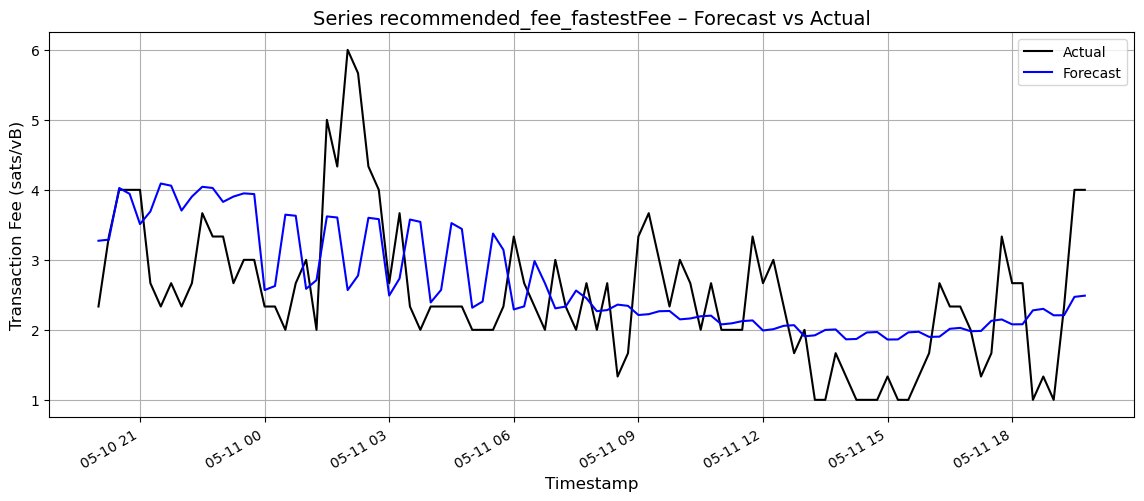

In [50]:
from plot_series import plot_series
plot_series(df_eval, sid="recommended_fee_fastestFee")
plt.show()

### Summary

This step:
- Quantifies forecasting accuracy with interpretable metrics
- Visualizes forecast sharpness, bias, and uncertainty
- Confirms that the model's confidence intervals are calibrated (or not)

You're now ready to interpret results, compare models, or export forecasts.

---
## 11. Tutorial to Use the Trained TFT Model

The Temporal Fusion Transformer (TFT) was trained to forecast **24 hours** (1 day) of Bitcoin transaction fees, using the **preceding 7 days** as historical context (encoder). To generate new forecasts, your input data must include **at least 7 days of continuous history**.


### 11.1 Set Encoder Data

We now set up the **encoder input** using the last 7 days of known data.

**Important:** All features used as known covariates must be **preprocessed and scaled in the same way** as during training. This includes:
- Matching the feature column structure
- Dropping unused or zero-value columns
- Keeping timestamp alignment and frequency (15-minute intervals)


### 11.1.1 Prepare Raw Data

In this subsection, we process raw data into a compatible input format. 

The raw data **must start at or after** `2025-03-05 02:00:00`, the beginning of the training window. Replace the first line of code with your own raw dataset if you're using new data.

In [318]:
# Replace this line with your actual data file path if needed
df_predict = pd.read_parquet("../data/raw/extracted_s3.parquet")  

# Preview the structure of the raw data
df_predict.head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 83 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   timestamp                                 5 non-null      int64  
 1   mempool_blocks_blockSize                  5 non-null      float64
 2   mempool_blocks_blockVSize                 5 non-null      float64
 3   mempool_blocks_nTx                        5 non-null      float64
 4   mempool_blocks_totalFees                  5 non-null      float64
 5   mempool_blocks_medianFee                  5 non-null      float64
 6   recommended_fee_fastestFee                5 non-null      float64
 7   recommended_fee_halfHourFee               5 non-null      float64
 8   recommended_fee_hourFee                   5 non-null      float64
 9   recommended_fee_economyFee                5 non-null      float64
 10  recommended_fee_minimumFee                

### Why These Steps Matter:

- Ensuring your data schema matches the training data is **critical to avoid shape mismatches or invalid inputs** during prediction.
- Dropping unused histogram bins prevents noise from degrading model performance.

Here, we check and remove **mempool fee histogram** bins that contain only zero values (i.e., no useful signal).

In [319]:
# Identify all histogram columns
hist_cols = [col for col in df_predict.columns if col.startswith("mempool_fee_histogram_bin_")]

# Check for columns with only 0.0 values (no signal)
zero_hist_cols = [col for col in hist_cols if (df_predict[col] == 0.0).all()]
print("Histogram columns with only 0 float values:")
print(zero_hist_cols)

# Drop known uninformative bins
cols_to_drop = [
    'mempool_fee_histogram_bin_300_350', 'mempool_fee_histogram_bin_350_400',
    'mempool_fee_histogram_bin_400_450', 'mempool_fee_histogram_bin_450_500',
    'mempool_fee_histogram_bin_500_550', 'mempool_fee_histogram_bin_550_600',
    'mempool_fee_histogram_bin_600_650', 'mempool_fee_histogram_bin_650_700',
    'mempool_fee_histogram_bin_700_750', 'mempool_fee_histogram_bin_750_800',
    'mempool_fee_histogram_bin_800_850', 'mempool_fee_histogram_bin_850_900',
    'mempool_fee_histogram_bin_900_950', 'mempool_fee_histogram_bin_950_1000',
    'mempool_fee_histogram_bin_1000_plus'
]

# Remove zero-signal columns from the DataFrame
df_predict.drop(columns=cols_to_drop, inplace=True)

Histogram columns with only 0 float values:
['mempool_fee_histogram_bin_300_350', 'mempool_fee_histogram_bin_350_400', 'mempool_fee_histogram_bin_400_450', 'mempool_fee_histogram_bin_450_500', 'mempool_fee_histogram_bin_500_550', 'mempool_fee_histogram_bin_550_600', 'mempool_fee_histogram_bin_600_650', 'mempool_fee_histogram_bin_650_700', 'mempool_fee_histogram_bin_700_750', 'mempool_fee_histogram_bin_750_800', 'mempool_fee_histogram_bin_800_850', 'mempool_fee_histogram_bin_850_900', 'mempool_fee_histogram_bin_900_950', 'mempool_fee_histogram_bin_950_1000', 'mempool_fee_histogram_bin_1000_plus']


Here, We standardize the `timestamp` column to datetime format and ensure the data is sorted chronologically.

In [320]:
# Convert UNIX timestamp to pandas datetime
df_predict['timestamp'] = pd.to_datetime(df_predict['timestamp'], unit='s')

# Sort rows in ascending order of time
df_predict.sort_values('timestamp', inplace=True)

# Reset DataFrame index
df_predict.reset_index(drop=True, inplace=True)

# Set timestamp as the DataFrame index
df_predict.set_index('timestamp', inplace=True)


Some price-related features are highly correlated. Here, we keep only the relevant one (`price_USD`).

In [321]:
# Drop unused price features
price_cols_to_drop = [col for col in df_predict.columns if col.startswith("price_") and col != "price_USD"]
df_predict.drop(columns=price_cols_to_drop, inplace=True)

# Preview the cleaned DataFrame
df_predict.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:12:13,2210077.0,997916.50,556.0,1615739.0,1.300082,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:14:41,2131827.0,997874.25,1030.0,2077770.0,1.300139,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:19:42,1986259.0,997882.00,1915.0,2663152.0,2.000000,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:24:41,1814202.0,997958.25,2710.0,3423846.0,2.413300,3.0,3.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:29:42,1604116.0,997937.50,3256.0,4136741.0,3.008581,4.0,3.0,3.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 11.1.2 Format and Normalize Data for Encoder Input

To forecast using the trained Temporal Fusion Transformer (TFT), we must **transform the raw 15-minute interval data** into the expected encoder format. This includes selecting relevant columns, reshaping the data into long format for multiple fee types, engineering time features, and applying normalization.

#### Why this step is important:
TFT models expect a specific input structure — including `series_id`, `time_idx`, and normalized continuous features. This preprocessing ensures consistency with the training format, which is **critical for accurate forecasting**.


In [322]:
ENC_LEN = 96 * 7  # 7 days of data at 15-minute intervals

# Resample to fixed 15-minute intervals and interpolate missing values
df_predict = df_predict.resample("15min").mean()
df_predict = df_predict.interpolate(method='linear')

# Keep only the last 7 days of data
df_predict = df_predict.iloc[-ENC_LEN:]

In [323]:
# Define target fee columns
fee_cols = [
    "recommended_fee_fastestFee",
    "recommended_fee_hourFee",
    "recommended_fee_halfHourFee",
    "recommended_fee_economyFee",
    "recommended_fee_minimumFee"
]

# Convert to long format: one row per series_id per timestamp
df_long = df_predict[fee_cols].copy()
df_long["timestamp"] = df_predict.index
df_long = df_long.melt(id_vars=["timestamp"], var_name="series_id", value_name="target")

In [324]:
# Merge with remaining features
features = df_predict.drop(columns=fee_cols).reset_index()
df_long = df_long.merge(features, on="timestamp", how="left")

# Sort for chronological consistency
df_long = df_long.sort_values(["series_id", "timestamp"]).reset_index(drop=True)


In [313]:
# Add time-related covariates
df_long["hour"] = df_long["timestamp"].dt.hour
df_long["minute"] = df_long["timestamp"].dt.minute
df_long["day_of_week"] = df_long["timestamp"].dt.dayofweek
df_long["month"] = df_long["timestamp"].dt.month


In [326]:
# Set time_idx as number of 15-min intervals since training base time
reference_time = pd.Timestamp("2025-03-05 02:00:00")
df_long["time_idx"] = ((df_long["timestamp"] - reference_time) / pd.Timedelta(minutes=15)).astype(int)

In [315]:
# Normalize continuous features (excluding categorical and time variables)
EXCLUDE = [
    "target",
    "time_idx",
    "hour",
    "minute",
    "day_of_week",
    "month",
    "series_id",
    "timestamp",
]
num_cols = df_long.select_dtypes("float64").columns.difference(EXCLUDE)
scaler = StandardScaler()
df_long.loc[:, num_cols] = scaler.fit_transform(df_long[num_cols])


In [316]:
encoder_df = df_long.copy()  # Final encoder input
encoder_df.head()

,timestamp,series_id,target,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,mempool_count,mempool_vsize,...,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300,hour,minute,day_of_week,month,time_idx
0,2025-04-08 10:00:00,recommended_fee_economyFee,1.0,-0.466052,-0.700035,-0.511464,0.188902,-0.145992,-0.809784,-0.879178,...,0.0,-0.269286,-0.058681,-0.108272,0.0,10,0,1,4,3296
1,2025-04-08 10:15:00,recommended_fee_economyFee,1.0,-1.849814,-1.959310,-1.511334,-0.490510,-0.274281,-1.093892,-1.107762,...,0.0,-0.269286,-0.058681,-0.108272,0.0,10,15,1,4,3297
2,2025-04-08 10:30:00,recommended_fee_economyFee,1.0,-0.776351,-0.399294,-1.314723,-0.174747,0.023079,-1.038863,-0.877528,...,0.0,-0.269286,-0.058681,-0.108272,0.0,10,30,1,4,3298
3,2025-04-08 10:45:00,recommended_fee_economyFee,1.0,-1.433145,-0.634857,-1.788581,-0.219543,-0.171086,-0.908516,-0.434397,...,0.0,-0.269286,-0.058681,-0.108272,0.0,10,45,1,4,3299
4,2025-04-08 11:00:00,recommended_fee_economyFee,1.0,-1.660007,-1.683180,-1.014487,-0.524377,-0.321184,-0.982988,-1.067843,...,0.0,-0.269286,-0.058681,-0.108272,0.0,11,0,1,4,3300


---
### 11.2 Set Decoder Data for Forecasting

After preparing the encoder input using 7 days of historical data, we now define the **decoder input**, which consists of the **next 24 hours (96 × 15-minute intervals)** where we want to make predictions. The model will rely on known covariates (like hour, day of week) to infer future patterns.

#### Why this step is important:
TFT is an encoder-decoder model — **the decoder requires future known inputs even for inference**. Without properly prepared decoder data (with consistent structure and `time_idx`), the model cannot perform forecasting.

In [247]:
# 1. Get the last available time_idx to start forecasting from the next step
last_data = encoder_df[lambda x: x.time_idx == x.time_idx.max()]
start_time = last_data["timestamp"].iloc[0] + pd.Timedelta(minutes=15)

In [248]:
# Define known covariates (they remain available into the future)
time_varying_known_covariates = ["time_idx", "hour", "minute", "day_of_week", "month"]
series_ids = encoder_df["series_id"].unique()

# 2. Create 96 timestamps (15min × 96 = 24h) for each series_id
future_timestamps = pd.date_range(start=start_time, periods=96, freq="15min")
decoder_future = pd.DataFrame({
    "timestamp": np.tile(future_timestamps, len(series_ids)),
    "series_id": np.repeat(series_ids, len(future_timestamps))
})


In [249]:
# 3. Recompute time index to match training setup
reference_time = pd.Timestamp("2025-03-05 02:00:00")
decoder_future["time_idx"] = ((decoder_future["timestamp"] - reference_time) / pd.Timedelta(minutes=15)).astype(int)


In [250]:
# 4. Add calendar-based known covariates for each timestamp
decoder_future["hour"] = decoder_future["timestamp"].dt.hour
decoder_future["minute"] = decoder_future["timestamp"].dt.minute
decoder_future["day_of_week"] = decoder_future["timestamp"].dt.dayofweek
decoder_future["month"] = decoder_future["timestamp"].dt.month

# Reorder columns for consistency
decoder_future = decoder_future[["series_id", "timestamp"] + time_varying_known_covariates]


In [251]:
# 5. Fill in remaining columns from encoder_df with default zeros (model expects full feature set)
all_columns = encoder_df.columns
decoder_full = decoder_future.copy()

# Add missing columns
for col in all_columns:
    if col not in decoder_full.columns:
        decoder_full[col] = 0

# Ensure column order matches encoder input
decoder_full = decoder_full[encoder_df.columns]


In [252]:
# 6. Concatenate encoder and decoder data — this forms the complete input for the model
df_combined = pd.concat([encoder_df, decoder_full], ignore_index=True)
df_combined.tail()

,timestamp,series_id,target,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,mempool_count,mempool_vsize,...,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300,hour,minute,day_of_week,month,time_idx
3835,2025-04-16 08:45:00,recommended_fee_minimumFee,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8,45,2,4,4059
3836,2025-04-16 09:00:00,recommended_fee_minimumFee,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9,0,2,4,4060
3837,2025-04-16 09:15:00,recommended_fee_minimumFee,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9,15,2,4,4061
3838,2025-04-16 09:30:00,recommended_fee_minimumFee,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9,30,2,4,4062
3839,2025-04-16 09:45:00,recommended_fee_minimumFee,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9,45,2,4,4063


---
### 11.3 Make Prediction Using the Trained TFT Model

After preparing the combined encoder and decoder dataset, we now load the trained Temporal Fusion Transformer model and use it to make 24-hour fee forecasts. This step outputs the predicted quantiles, ready for analysis or visualization.

#### Why this step is important:
This is where your trained model is put into action. The model uses past and future known covariates to forecast the target variable (e.g., `recommended_fee_fastestFee`). By analyzing multiple quantiles (0.1, 0.5, 0.9), you capture not only the median forecast but also the uncertainty.


In [255]:
# Load model checkpoint — must match a file saved by the ModelCheckpoint callback
ckpt_path = "./saved_models/best-model-epoch=13-val_loss=0.1967.ckpt"

model = TemporalFusionTransformer.load_from_checkpoint(
    checkpoint_path = ckpt_path,
    map_location    = "cuda"  # Use "cpu" if GPU is unavailable
)

C:\Users\davyx\anaconda3\envs\satcast\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\davyx\anaconda3\envs\satcast\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [256]:
# Make prediction using prepared encoder + decoder combined data
prediction = model.predict(
    df_combined,
    mode="raw",             # Return raw quantile predictions
    return_index=True,      # Include timestamp and metadata
    return_x=True,          # Return inputs (x) for plotting
    trainer_kwargs=dict(accelerator="gpu")  # Use GPU for fast inference
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\davyx\anaconda3\envs\satcast\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


In [257]:
# Inspect shape of decoder output (batch_size, prediction_length)
batch, pred_len = prediction.x["decoder_time_idx"].shape

In [258]:
# Convert PyTorch tensor to NumPy array for further processing
prediction_np = prediction.output.prediction.detach().cpu().numpy()

# Extract individual quantiles: 0.1 (lower), 0.5 (median), 0.9 (upper)
step_pred_0_1, step_pred_0_5, step_pred_0_9 = [
    prediction_np[:, :, q].reshape(-1) for q in range(3)
]

In [261]:
# Package predictions into a DataFrame for analysis or visualization
df_prediction = pd.DataFrame(
    dict(
        timestamp = df_true["timestamp"],        # Ground truth timestamps
        time_idx  = df_true["time_idx"],         # Time index
        series_id = decoder_data["series_id"],   # Which fee series
        y_true    = df_true["target"],           # Actual (if known)
        y_pred_0_1 = step_pred_0_1,              # Predicted lower bound
        y_pred_0_5 = step_pred_0_5,              # Predicted median
        y_pred_0_9 = step_pred_0_9,              # Predicted upper bound
    )
)
df_prediction.head()

,timestamp,time_idx,series_id,y_true,y_pred_0_1,y_pred_0_5,y_pred_0_9
3872,2025-04-14 10:00:00,3872,recommended_fee_economyFee,2.000000,0.980530,1.110283,1.897833
3873,2025-04-14 10:15:00,3873,recommended_fee_economyFee,2.000000,0.983413,1.117720,1.932627
3874,2025-04-14 10:30:00,3874,recommended_fee_economyFee,2.000000,0.985695,1.125769,1.968948
3875,2025-04-14 10:45:00,3875,recommended_fee_economyFee,1.666667,0.986921,1.128428,1.984915
3876,2025-04-14 11:00:00,3876,recommended_fee_economyFee,1.000000,0.987445,1.129948,1.991590


---
### 11.3.1 Visualize the Prediction Results
We now visualize the 7-day historical input and 24-hour forecast, along with the prediction intervals.

In [262]:
def plot_series(sid, ax=None):
    """
    Plot 7 days of history and forecast with prediction intervals for a specific series_id.

    Parameters:
    -----------
    sid : str or int
        The series_id identifying the time series to plot.
    ax : matplotlib.axes.Axes, optional
        Optional matplotlib Axes to draw the plot on.

    Returns:
    --------
    ax : matplotlib.axes.Axes
        The matplotlib Axes object with the plotted data.
    """
    # Forecast subset (from prediction output)
    forecast_subset = df_prediction[df_prediction.series_id == sid]

    # Determine the forecast start time
    forecast_start_time = forecast_subset["timestamp"].min()

    # Historical input: 7-day encoder history from df_predict
    history_subset = encoder_df[
        (encoder_df.series_id == sid) &
        (encoder_df.timestamp >= forecast_start_time - pd.Timedelta(days=7)) &
        (encoder_df.timestamp < forecast_start_time)
    ]

    # Create figure/axes if not provided
    if ax is None:
        _, ax = plt.subplots(figsize=(16, 5))  # wider format

    # Plot encoder history (actual past values)
    ax.plot(
        history_subset.timestamp,
        history_subset.target,
        label="History (7 days)",
        color="black"
    )

    # Plot forecast median (quantile 0.5)
    ax.plot(
        forecast_subset.timestamp,
        forecast_subset.y_pred_0_5,
        label="Forecast (Median)",
        color="blue"
    )

    # Plot prediction interval: 0.1 to 0.9 quantiles
    ax.fill_between(
        forecast_subset.timestamp,
        forecast_subset.y_pred_0_1,
        forecast_subset.y_pred_0_9,
        color="blue",
        alpha=0.3,
        label="Prediction Interval (0.1–0.9)"
    )

    # Style and annotate
    ax.set_title(f"Series {sid} — 7 Days History + Forecast")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Transaction Fee (sats/vB)")
    ax.grid(True)
    ax.legend()

    return ax


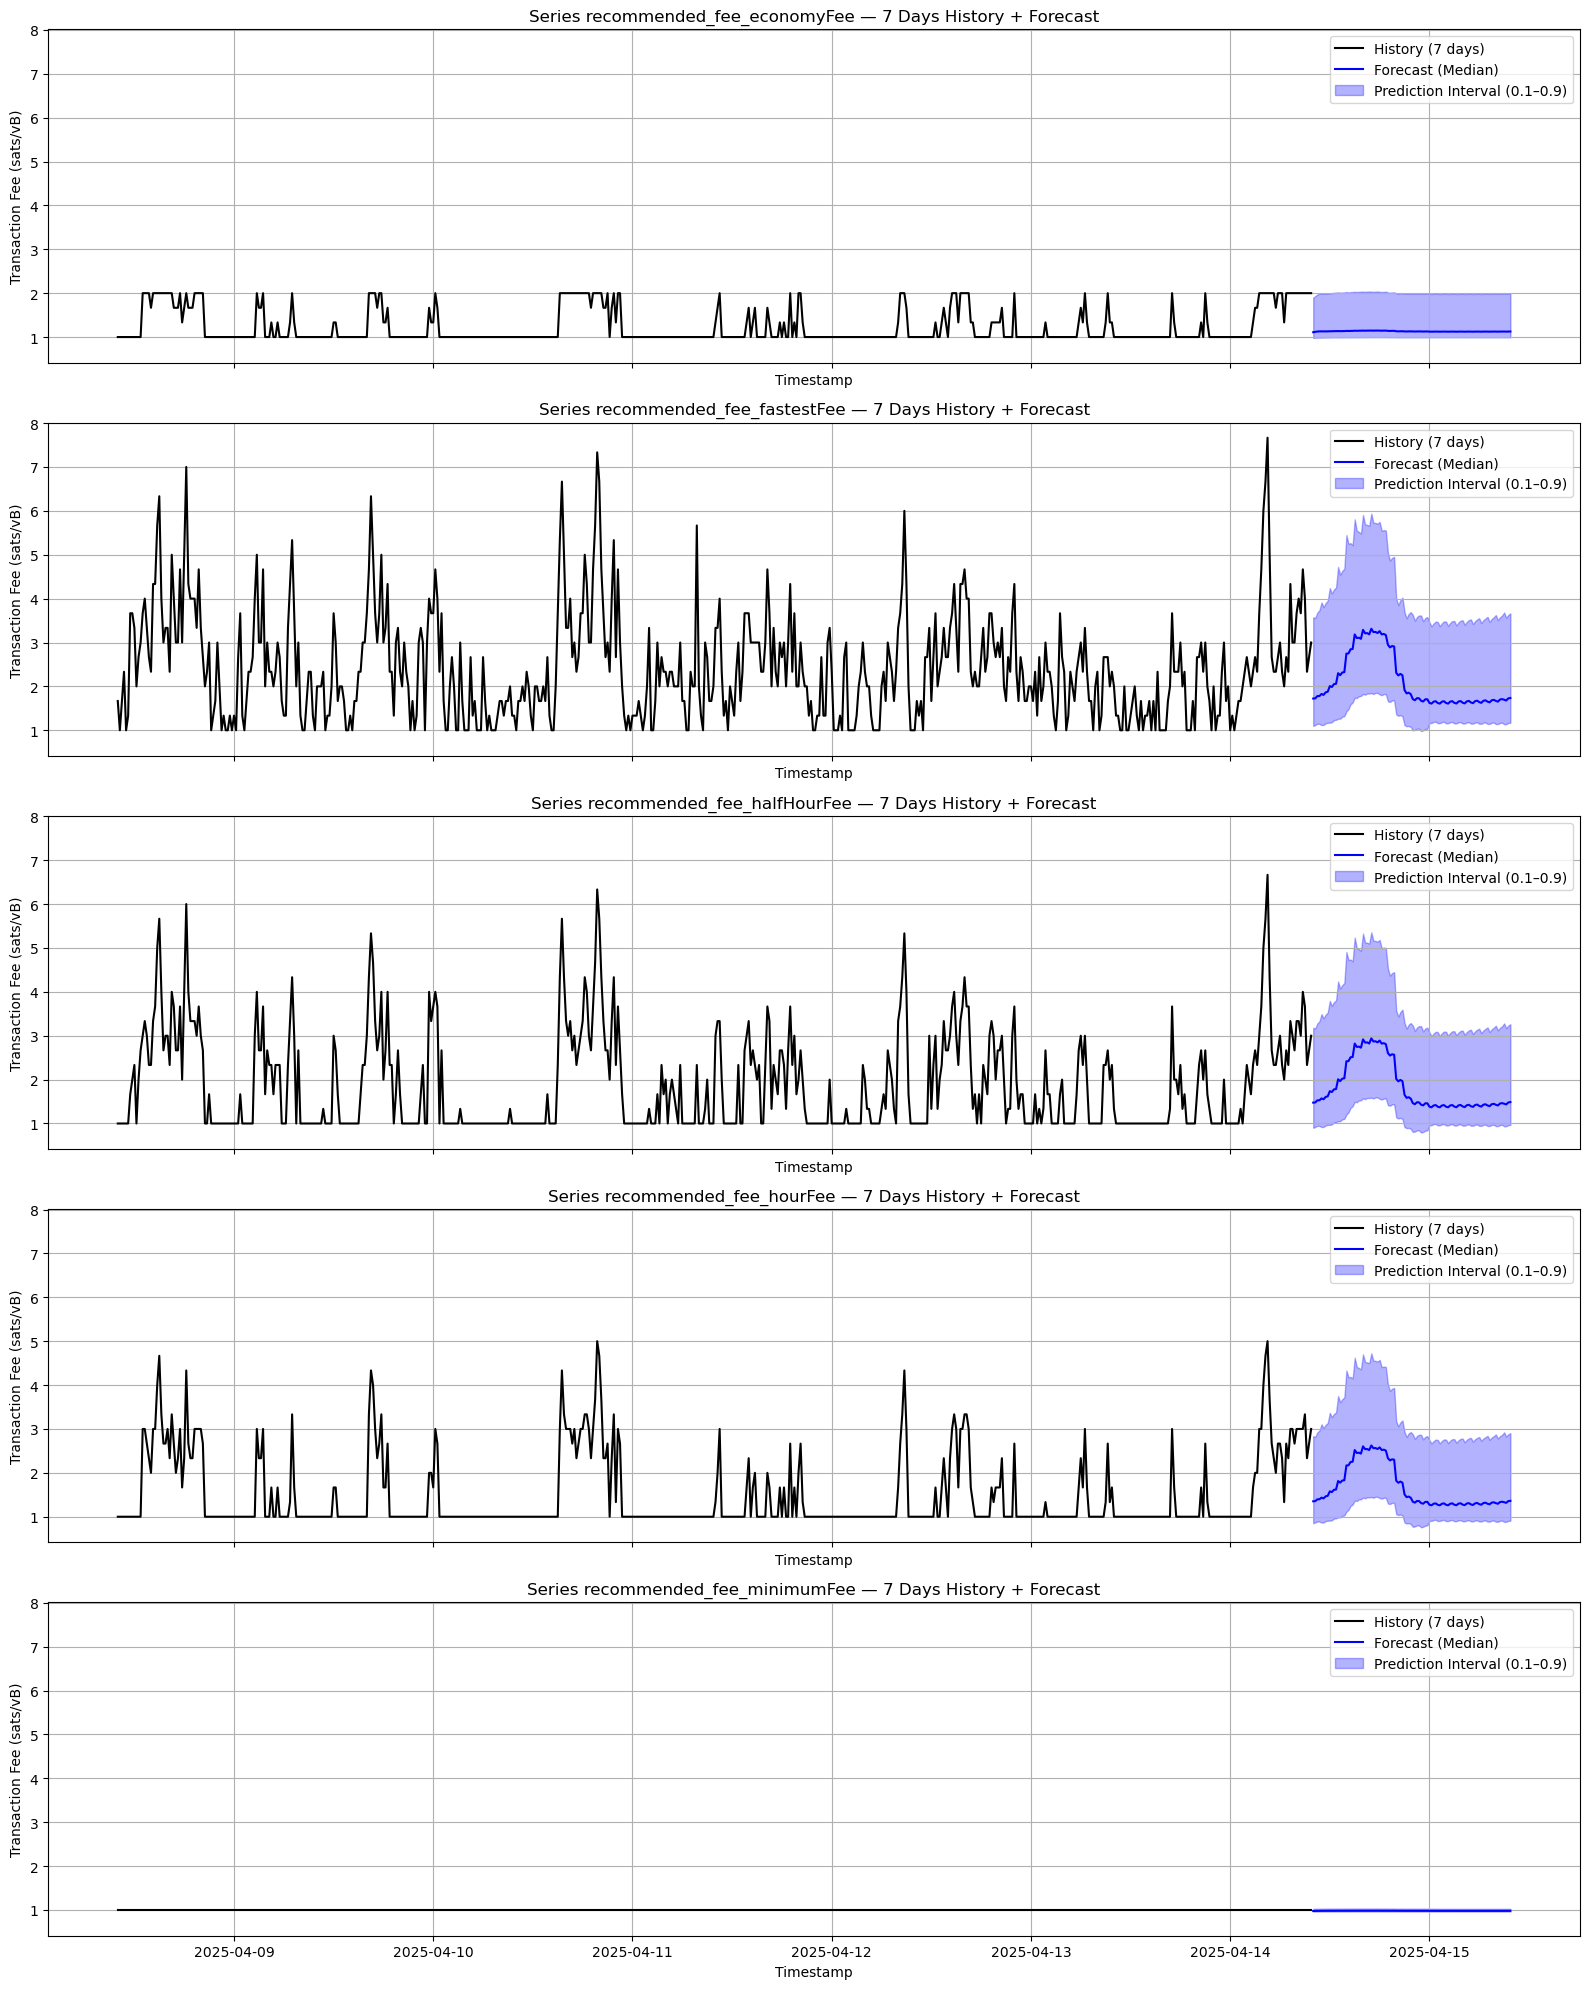

In [264]:
# Visualize the 5 fee series with shared axes
fig, axs = plt.subplots(5, 1, figsize=(16, 20), sharex=True, sharey=True)
for i, sid in enumerate(df_prediction.series_id.unique()[:5]):
    plot_series(sid, ax=axs[i])

plt.tight_layout()
plt.show()


### Conclusion

In this notebook, we walked through the full pipeline of training and using a **Temporal Fusion Transformer (TFT)** for probabilistic Bitcoin transaction fee forecasting. Starting from raw data ingestion, preprocessing, and feature engineering, we trained the model using historical mempool data and external covariates. Finally, we demonstrated how to apply the trained model to **forecast future fees using new data**, visualizing both the median predictions and associated uncertainty.

With this pipeline, you now have a solid foundation to **adapt TFT to real-time fee forecasting tasks**, monitor fee dynamics, and integrate predictions into decision-making systems or blockchain infrastructure.
